<a href="https://colab.research.google.com/github/VincentZuo/Code/blob/main/GPT_backtrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install backtrader
!pip install backtrader[plotting]

In [ ]:
qqq_path = 'QQQ.csv'

In [ ]:
# Importing Backtrader
import backtrader as bt
import pandas as pd

# Defining the Strategy
class SMACrossover(bt.Strategy):
    params = (('short_period', 10), ('long_period', 50),)

    def __init__(self):
        self.sma_short = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.short_period)
        self.sma_long = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.long_period)
        self.crossover = bt.indicators.CrossOver(self.sma_short, self.sma_long)

    def next(self):
        if self.crossover > 0:  # if short-term SMA crosses above long-term SMA
            self.buy()
        elif self.crossover < 0:  # if short-term SMA crosses below long-term SMA
            self.close()  # close long position

# Preparing Data
data_feed = bt.feeds.YahooFinanceCSVData(
    dataname=qqq_path,
    fromdate=pd.Timestamp('2020-01-01'),
    todate=pd.Timestamp('2021-01-01'),
    reverse=False)

# Setting Up Backtesting Environment
cerebro = bt.Cerebro()
cerebro.addstrategy(SMACrossover)
cerebro.adddata(data_feed)
cerebro.broker.set_cash(10000)
cerebro.run()


In [ ]:
# Custom Indicator for TD Sequential Setup Count
class TDSequentialSetup(bt.Indicator):
    lines = ('buy_setup', 'sell_setup',)
    params = (('setup_length', 9),)

    def __init__(self):
        self.addminperiod(self.params.setup_length + 1)

    def next(self):
        # Buy Setup
        buy_condition = [(self.data.close[i] > self.data.close[i - 4]) for i in range(-self.params.setup_length + 1, 1)]
        if all(buy_condition):
            self.lines.buy_setup[0] = self.params.setup_length
        elif self.lines.buy_setup[-1] and not buy_condition[-1]:
            self.lines.buy_setup[0] = 0
        elif self.lines.buy_setup[-1]:
            self.lines.buy_setup[0] = self.lines.buy_setup[-1] + 1
        else:
            self.lines.buy_setup[0] = 1 if buy_condition[-1] else 0

        # Sell Setup
        sell_condition = [(self.data.close[i] < self.data.close[i - 4]) for i in range(-self.params.setup_length + 1, 1)]
        if all(sell_condition):
            self.lines.sell_setup[0] = self.params.setup_length
        elif self.lines.sell_setup[-1] and not sell_condition[-1]:
            self.lines.sell_setup[0] = 0
        elif self.lines.sell_setup[-1]:
            self.lines.sell_setup[0] = self.lines.sell_setup[-1] + 1
        else:
            self.lines.sell_setup[0] = 1 if sell_condition[-1] else 0

# TD Sequential Strategy
class TDSequentialStrategy(bt.Strategy):

    def __init__(self):
        self.ma20 = bt.indicators.SimpleMovingAverage(self.data.close, period=20)
        self.td_setup = TDSequentialSetup(self.data)

    def next(self):
        cash = self.broker.get_cash()
        position_size = self.broker.getposition(self.data).size

        # If current price lower than ma20
        if self.data.close[0] < self.ma20[0]:
            if self.td_setup.buy_setup[0] == 9:
                self.order_target_percent(target=0.5)
            elif self.td_setup.buy_setup[0] == 1 and position_size > 0:
                self.close()
            elif self.td_setup.sell_setup[0] == 9 and position_size > 0:
                self.close()

        # If current price higher than ma20
        elif self.data.close[0] > self.ma20[0]:
            if self.td_setup.buy_setup[0] == 9:
                self.order_target_percent(target=1.0)
            elif self.td_setup.sell_setup[0] == 9 and position_size > 0:
                self.order_target_percent(target=0.5)
            elif self.td_setup.buy_setup[0] == 1 and position_size > 0:
                self.close()
            elif self.td_setup.sell_setup[0] == 1:
                self.order_target_percent(target=1.0)

# Backtest Configuration
cerebro = bt.Cerebro()
cerebro.addstrategy(TDSequentialStrategy)
data_feed = bt.feeds.YahooFinanceCSVData(
    dataname=qqq_path,
    fromdate=pd.Timestamp('2019-01-01'),
    todate=pd.Timestamp('2021-01-01'),
    reverse=False)
cerebro.adddata(data_feed)
cerebro.broker.set_cash(10000)
cerebro.run()
cerebro.plot(style='candlestick')


[[<Figure size 640x480 with 5 Axes>]]

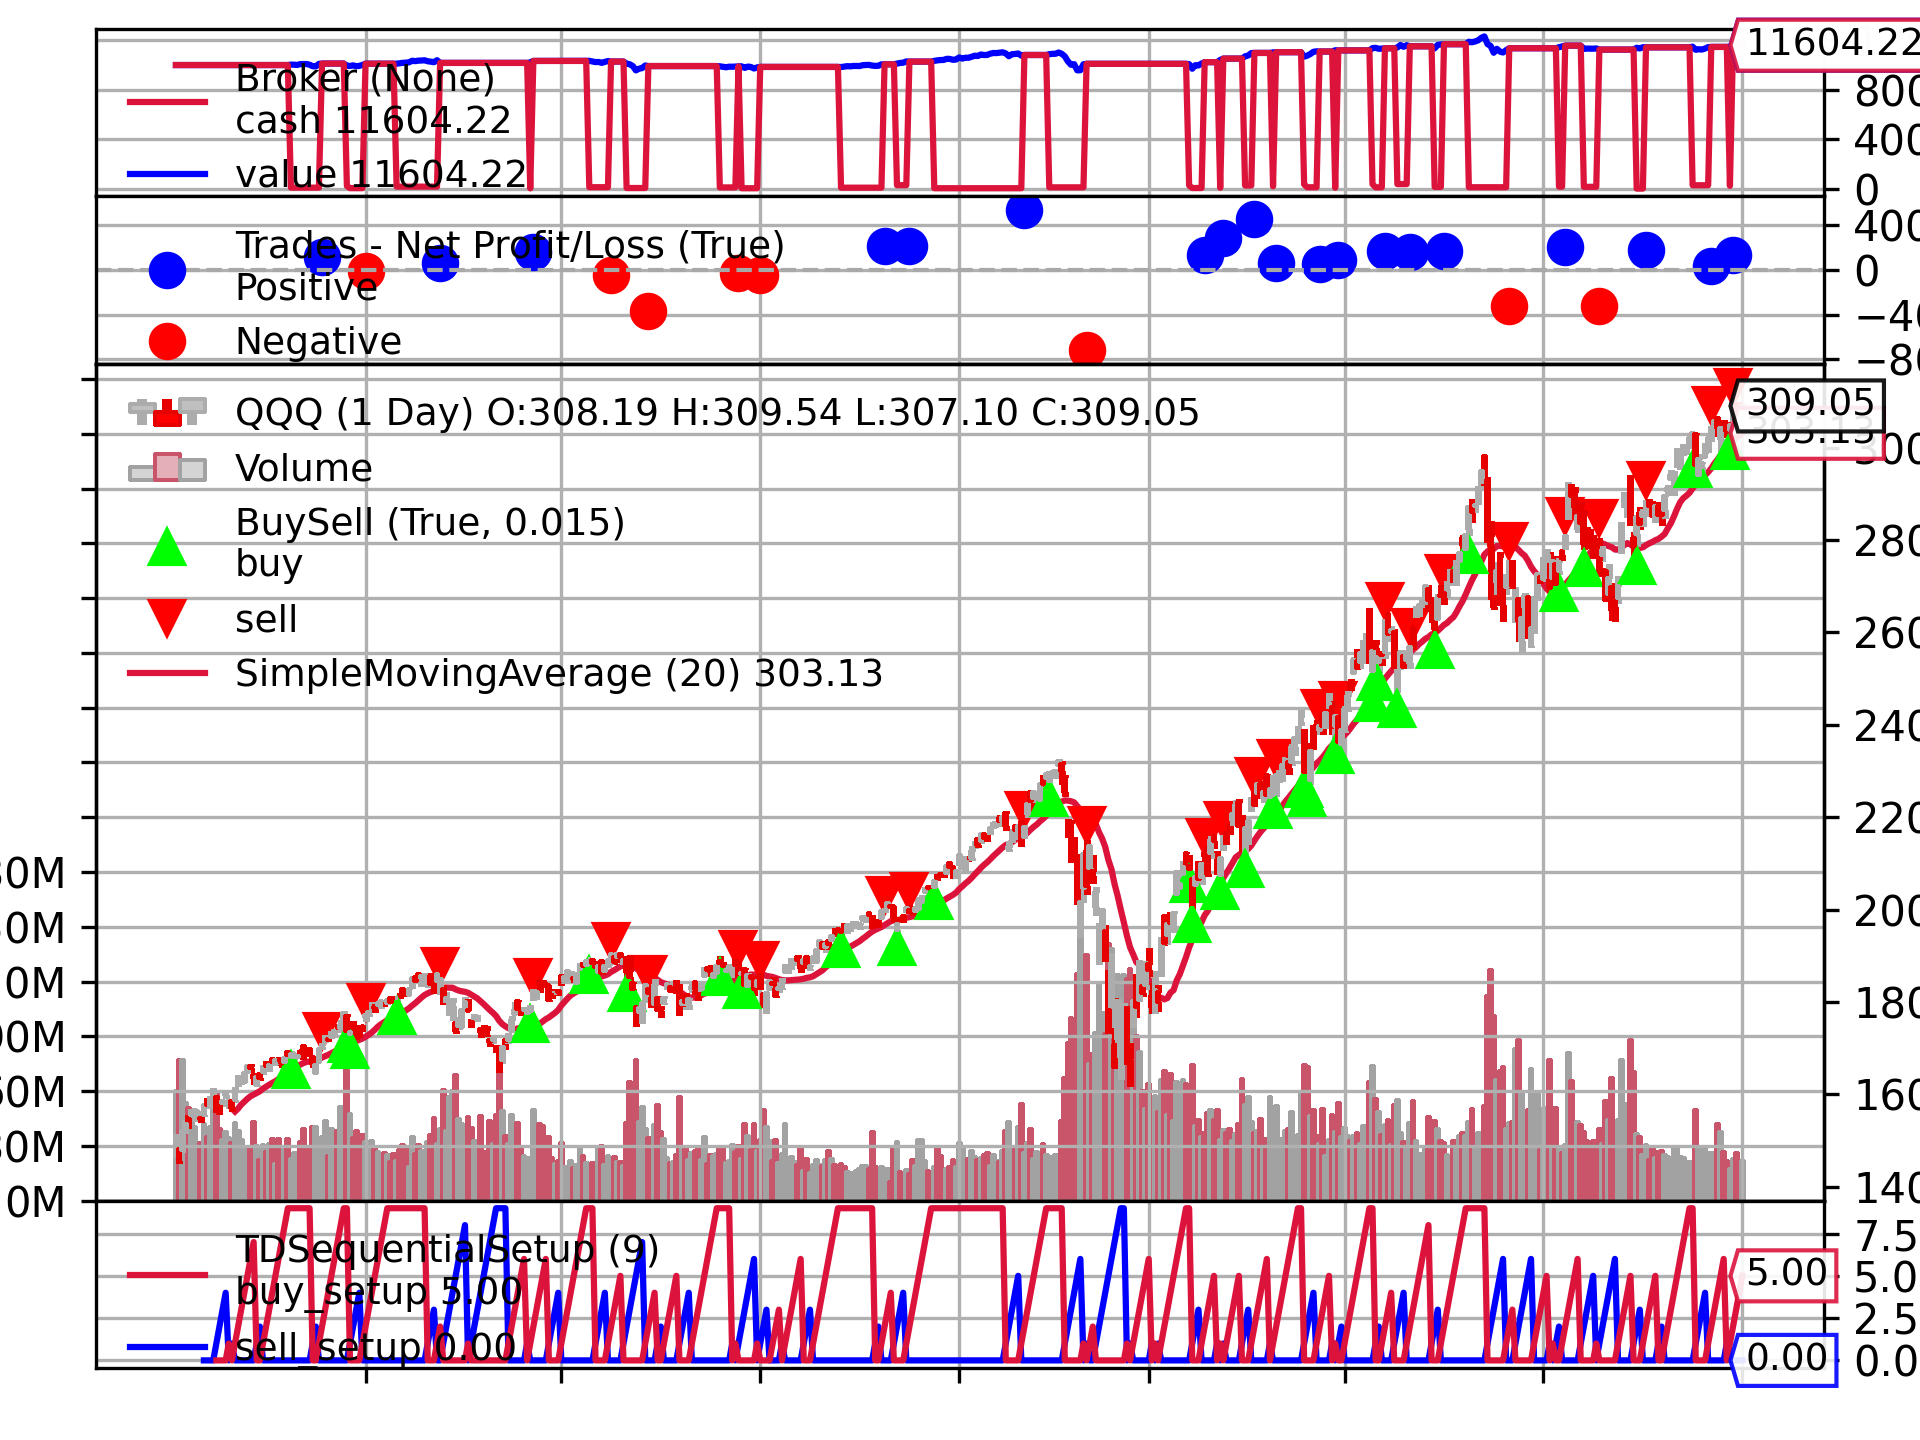

In [ ]:
from google.colab import files
from IPython.display import Image
chart_file = 'result.png'
cerebro.plot()[0][0].savefig(chart_file, dpi=300)
Image(open(chart_file, 'rb').read())